## ISA 491
## Project Modeling
## Group 4

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [69]:
# Load Training Data
file_path = '/content/drive/MyDrive/Fall 2024/ISA 491/Final Project/data/group_4_balanced_training.csv' # Will's GDrive Path
file_path = 'group_4_balanced_training.csv'
df = pd.read_csv(file_path)

# Split X and y
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Rename columns to avoid errors
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Additional 80/20 split to avoid overfitting on real test data (random_state = 19)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87110 entries, 0 to 87109
Data columns (total 50 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            87110 non-null  float64
 1   int_rate                             87110 non-null  float64
 2   issue_d                              87110 non-null  int64  
 3   dti                                  87110 non-null  float64
 4   earliest_cr_line                     87110 non-null  int64  
 5   open_acc                             87110 non-null  float64
 6   revol_util                           87110 non-null  float64
 7   total_acc                            87110 non-null  float64
 8   fico_range_high                      87110 non-null  float64
 9   last_credit_pull_d                   87110 non-null  int64  
 10  emp_title_missing_indicator          87110 non-null  int64  
 11  bankruptcy_flag             

##**Dimension Reduction for Efficiency**

####**Dimension Reduction using Logistic Regression**

In [70]:
# Creating a copy of the X Data before dropping columns
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

# Dimension Reduction using Logistic Regression
lr = sm.Logit(y_train, sm.add_constant(X_train_lr)).fit()

# Iterate until all p-values are below the significance level (0.05)
dropped_cols = []
while True:
    insignificant_cols = []
    p_values = lr.pvalues[1:]  # Exclude the constant

    for col, p_val in p_values.items():
        if p_val > 0.05:
            insignificant_cols.append(col)

    if not insignificant_cols:
        break

    # Find the column with the highest p-value among insignificant ones
    col_to_drop = p_values[insignificant_cols].idxmax()

    print(f"Dropping column '{col_to_drop}' with p-value: {p_values[col_to_drop]}")
    X_train_lr = X_train_lr.drop(columns=[col_to_drop])
    X_test_lr = X_test_lr.drop(columns=[col_to_drop])
    lr = sm.Logit(y_train, sm.add_constant(X_train_lr)).fit()
    dropped_cols.append(col_to_drop)

print(lr.summary())

Optimization terminated successfully.
         Current function value: 0.602988
         Iterations 6
Dropping column 'home_ownership_other' with p-value: 0.9999966242423495
Optimization terminated successfully.
         Current function value: 0.602988
         Iterations 6
Dropping column 'emp_length___1_year' with p-value: 0.9235385073328531
Optimization terminated successfully.
         Current function value: 0.602988
         Iterations 6
Dropping column 'int_rate' with p-value: 0.9057845875778666
Optimization terminated successfully.
         Current function value: 0.602988
         Iterations 6
Dropping column 'emp_length_5_years' with p-value: 0.7453559656307434
Optimization terminated successfully.
         Current function value: 0.602989
         Iterations 6
Dropping column 'emp_length_10__years' with p-value: 0.5930051528045155
Optimization terminated successfully.
         Current function value: 0.602991
         Iterations 6
Dropping column 'emp_length_3_years' with p

In [71]:
X_train_lr.shape # reduced by 19 columns

(69688, 30)

####**Dimension Reduction using Principal Component Analysis**

In [72]:
from sklearn.decomposition import PCA

# Initialize PCA with desired number of components (e.g., to retain 95% of variance)
pca = PCA(n_components=0.99)  # or n_components=k for k principal components

# Fit PCA on the training data
pca.fit(X_train)

# Transform both training and testing data using the fitted PCA
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))
print("Number of components:", pca.n_components_)

Explained Variance Ratio: [0.93275685 0.04001436 0.02722879]
Total Explained Variance: 0.9999999999999996
Number of components: 3


In [73]:
X_train_pca.shape # reduced by 46 columns

(69688, 3)

##**Modeling**

Once grid searches run, save model params and ONLY RUN THAT MODEL (grid search will take hours)

In [74]:
# Define function for comparing metrics
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def create_model_metrics_df(models, X_test, y_test):
    """
    Creates a Pandas DataFrame containing model names and their performance metrics.

    Args:
        models: A dictionary where keys are model names (strings) and values are trained model objects.
        X_test: The test features.
        y_test: The test labels.

    Returns:
        A Pandas DataFrame with model names and metrics (accuracy, precision, recall, f1, AUC-ROC).
        Returns None if an error occurs.
    """
    try:
        metrics = []
        for model_name, model in models.items():
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc_roc = roc_auc_score(y_test, y_prob)

            metrics.append({
                'Model': model_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC-ROC': auc_roc
            })
        return pd.DataFrame(metrics)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

####**Decision Tree**

In [75]:
# # Decision Tree Grid Search (Using LR data)
# dt_params = {
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5],
#     'criterion': ['gini', 'entropy']
# }
# dt = DecisionTreeClassifier(random_state=42)
# dt_grid_lr = GridSearchCV(dt, dt_params, scoring='roc_auc', cv=5)
# dt_grid_lr.fit(X_train_lr, y_train)
# print("Best Decision Tree Params:", dt_grid_lr.best_params_)

In [76]:
# # Decision Tree Grid Search (Using PCA data)
# dt_params = {
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5],
#     'criterion': ['gini', 'entropy']
# }
# dt = DecisionTreeClassifier(random_state=42)
# dt_grid_pca = GridSearchCV(dt, dt_params, scoring='roc_auc', cv=5)
# dt_grid_pca.fit(X_train_pca, y_train)
# print("Best Decision Tree Params:", dt_grid_pca.best_params_)

In [77]:
# ConfusionMatrixDisplay.from_estimator(dt_grid_lr.best_estimator_, X_test_lr, y_test, cmap='Blues')
# ConfusionMatrixDisplay.from_estimator(dt_grid_lr.best_estimator_, X_test_lr, y_test, cmap='Blues')

In [78]:
dt = DecisionTreeClassifier(random_state=42, criterion= 'gini', max_depth= None, min_samples_leaf= 5, min_samples_split= 2)
dt.fit(X_train_pca, y_train)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

#### Bagging

In [79]:
# # Bagging (PCA Data)
# bagging_params = {
#     'n_estimators': [10, 50, 100],
#     'max_samples': [0.5, 0.7, 1.0]
# }
# bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)
# bagging_grid = GridSearchCV(bagging, bagging_params, scoring='roc_auc', cv=5)
# bagging_grid.fit(X_train_pca, y_train)
# print("Best Bagging Params:", bagging_grid.best_params_)

In [80]:
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42, max_samples= 0.5, n_estimators= 100)
bagging.fit(X_train_pca, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.5,
                  n_estimators=100, random_state=42)

#### Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
'''
param_grid = {
    'n_estimators': [40, 60, 90],
    'max_depth': [None, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_samples': [0.8, 0.4, 0.6]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
rf_grid.fit(X_train_pca, y_train)
'''

"\nparam_grid = {\n    'n_estimators': [40, 60, 90],\n    'max_depth': [None, 5, 10],\n    'criterion': ['gini', 'entropy'],\n    'max_samples': [0.8, 0.4, 0.6]\n}\n\nrf = RandomForestClassifier(random_state=42)\nrf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')\nrf_grid.fit(X_train_pca, y_train)\n"

In [82]:
#best estimates
# rf_grid.best_params_

In [83]:
#create model with best parameters
#use random state 42 for comparability
rf = RandomForestClassifier(random_state=42, criterion= 'gini', max_depth= None, max_samples= 0.4, n_estimators= 90)
rf.fit(X_train_pca, y_train)

RandomForestClassifier(max_samples=0.4, n_estimators=90, random_state=42)

#### Boosting

In [84]:
# # Gradient Boosing
# gb_params = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'max_depth': [3, 5, 7]
# }
# gb = GradientBoostingClassifier(random_state=42)
# gb_grid = GridSearchCV(gb, gb_params, cv=5, n_jobs=-1, scoring='accuracy')
# gb_grid.fit(X_train_pca, y_train)
# print("Best Gradient Boosting Params:", gb_grid.best_params_)

In [85]:
gb = GradientBoostingClassifier(random_state=42, learning_rate= 0.1, max_depth= 7, n_estimators= 200)
gb.fit(X_train_pca, y_train)

GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=42)

In [86]:
# # Best grid from old doccument
# param_grid = {
#     'learning_rate': [0.001, 0.005, 0.01, 0.02],  # Finer values around the best
#     'n_estimators': [800, 1000, 1200, 1500],  # Explore higher estimators
#     'max_depth': [6, 7, 8, 9]  # Refine around the best depth
# }
# gb = GradientBoostingClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# grid_search.fit(X_train_pca, y_train)
# print("Best Hyperparameters:", grid_search.best_params_)

In [87]:
# # XGBoost
# xgb_params = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'max_depth': [3, 5, 7]
# }
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, n_jobs=-1, scoring='accuracy')
# xgb_grid.fit(X_train_pca, y_train)
# print("Best XGBoost Params:", xgb_grid.best_params_)

In [88]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, learning_rate= 0.1, max_depth= 7, n_estimators= 100)
xgb.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:02:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [89]:
# # Best grid from old doccument
# param_grid = {
#     'learning_rate': [0.02, 0.025, 0.03],  # Finer values around the best
#     'n_estimators': [500, 600, 700],  # Explore higher estimators
#     'max_depth': [7, 8, 9]  # Refine around the best depth
# }
# xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# xgb3_g = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# xgb3_g.fit(X_train_pca, y_train)
# print("Best Hyperparameters:", xgb3_g.best_params_)

In [90]:
# create_model_metrics_df({"XGB":xgb3_g.best_estimator_}, X_test_pca, y_test)

In [91]:
# create_model_metrics_df({"XGB":xgb3_g.best_estimator_}, X_test_pca, y_test)

In [92]:
xgb3= XGBClassifier(learning_rate=0.02, max_depth=7, n_estimators=800, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb3.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:02:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [93]:
# try changing hyperparameters
xgb3= XGBClassifier(learning_rate=0.02, max_depth=7, n_estimators=1600, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb3.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:02:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1600,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [94]:
create_model_metrics_df({"XGB":xgb3}, X_test_pca, y_test)

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,XGB,0.799966,0.825459,0.755682,0.789031,0.860817


#### Logistic Regression

In [95]:
# # Logistic Regression
# logreg_params = {
#     'penalty': ['l2', 'l1'],
#     'C': [0.01, 0.1, 1, 10],
#     'solver': ['lbfgs', 'liblinear']
# }
# logreg = LogisticRegression(random_state=42)
# logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, n_jobs=-1, scoring='accuracy')
# logreg_grid.fit(X_train_pca, y_train)
# print("Best Logistic Regression Params:", logreg_grid.best_params_)


In [96]:
logreg = LogisticRegression(random_state=42, C= 10, penalty= 'l2', solver= 'liblinear')
logreg.fit(X_train_pca, y_train)

LogisticRegression(C=10, random_state=42, solver='liblinear')

#### Neural Network

In [97]:
from sklearn.neural_network import MLPClassifier

# # Define the MLPClassifier
# mlp = MLPClassifier(random_state=42)

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
#     'activation': ['relu', 'tanh', 'logistic'],
#     'solver': ['adam', 'sgd'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate_init': [0.001, 0.01],
#     'max_iter': [200, 500]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# # Fit to the training data
# grid_search.fit(X_train_pca, y_train)

# # Get the best model
# best_mlp = grid_search.best_estimator_
# print("Best Hyperparameters:", grid_search.best_params_)


In [98]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42, activation= 'relu', alpha= 0.0001, hidden_layer_sizes= (100, 100), learning_rate_init= 0.01, max_iter= 500)
mlp.fit(X_train_pca, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate_init=0.01,
              max_iter=500, random_state=42)

In [99]:
X_train_pca.shape

(69688, 3)

In [100]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
'''
# Define the parameter grid with fewer options
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (200, 200)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.01, 0.1],
    'batch_size': [32, 64],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000]
}

# Set up RandomizedSearchCV with a smaller number of iterations
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train_pca, y_train)

# Get the best model
best_mlp = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)
'''

'\n# Define the parameter grid with fewer options\nparam_dist = {\n    \'hidden_layer_sizes\': [(50,), (100,), (200, 200)],\n    \'activation\': [\'relu\', \'tanh\'],\n    \'alpha\': [0.0001, 0.001],\n    \'learning_rate_init\': [0.01, 0.1],\n    \'batch_size\': [32, 64],\n    \'learning_rate\': [\'constant\', \'adaptive\'],\n    \'max_iter\': [1000]\n}\n\n# Set up RandomizedSearchCV with a smaller number of iterations\nrandom_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=20, cv=3, scoring=\'accuracy\', n_jobs=-1, verbose=2, random_state=42)\n\n# Fit the model\nrandom_search.fit(X_train_pca, y_train)\n\n# Get the best model\nbest_mlp = random_search.best_estimator_\nprint("Best Hyperparameters:", random_search.best_params_)\n'

In [101]:
# mlp = MLPClassifier(random_state=42, max_iter= 1000, learning_rate_init= 0.01, learning_rate= 'constant', hidden_layer_sizes= (200, 200), batch_size= 32, alpha= 0.001, activation= 'tanh')
# mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='tanh', alpha=0.001, batch_size=32,
              hidden_layer_sizes=(200, 200), learning_rate_init=0.01,
              max_iter=1000, random_state=42)

In [102]:
#try new hidden layers
mlp = MLPClassifier(random_state=42, max_iter= 1000, learning_rate_init= 0.01, learning_rate= 'constant', hidden_layer_sizes= (60, 60, 50), batch_size= 32, alpha= 0.001, activation= 'tanh')
mlp.fit(X_train_pca, y_train)

MLPClassifier(activation='tanh', alpha=0.001, batch_size=32,
              hidden_layer_sizes=(60, 60, 50), learning_rate_init=0.01,
              max_iter=1000, random_state=42)

#### Model Metrics/Confusion Matrixs

In [103]:
# Model Metrics (On Training version of Test Set (avoiding overfitting))
models = {
    "Decision Tree (PCA)": dt,
    "Bagging (PCA)": bagging,
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "XGBoost": xgb,
    "Logistic Regression": logreg,
    "MLP Classifier": mlp
}

# Create the DataFrame
model_metrics_df = create_model_metrics_df(models, X_test_pca, y_test)

model_metrics_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Decision Tree (PCA),0.754850,0.756935,0.743506,0.750161,0.815608
1,Bagging (PCA),0.793594,0.813623,0.756262,0.783894,0.852604
2,Random Forest,0.788945,0.803311,0.759624,0.780857,0.848230
3,Gradient Boosting,0.791298,0.811361,0.753595,0.781412,0.855156
4,XGBoost,0.793365,0.816612,0.751276,0.782582,0.856667
5,Logistic Regression,0.634428,0.623318,0.660830,0.641526,0.630527
6,MLP Classifier,0.666456,0.656399,0.684485,0.670148,0.706798


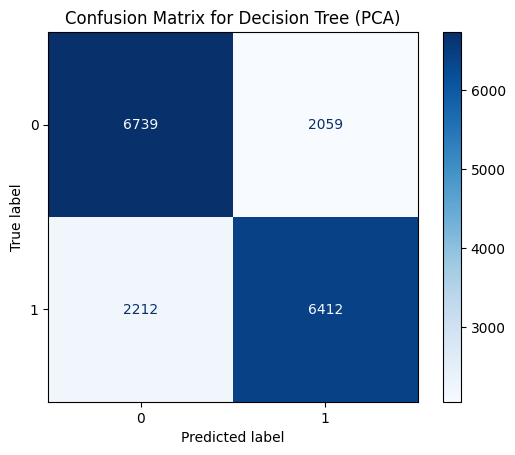

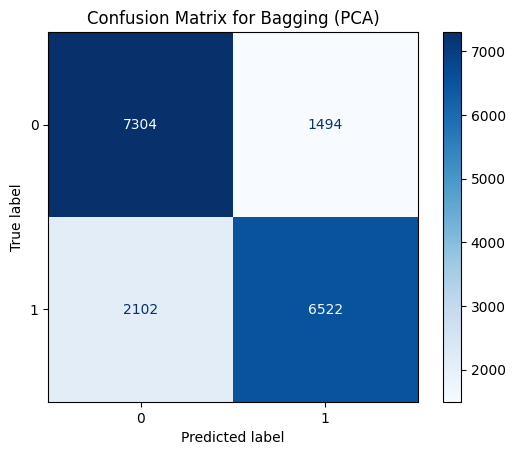

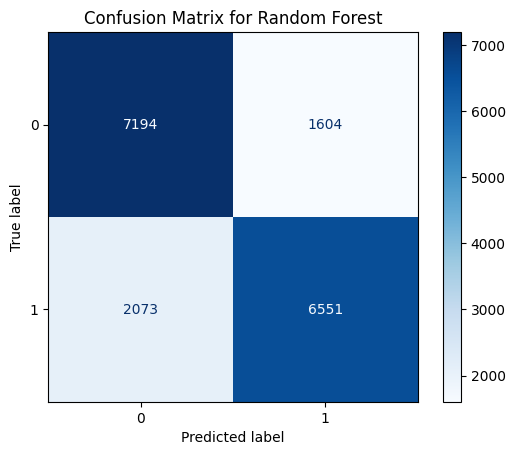

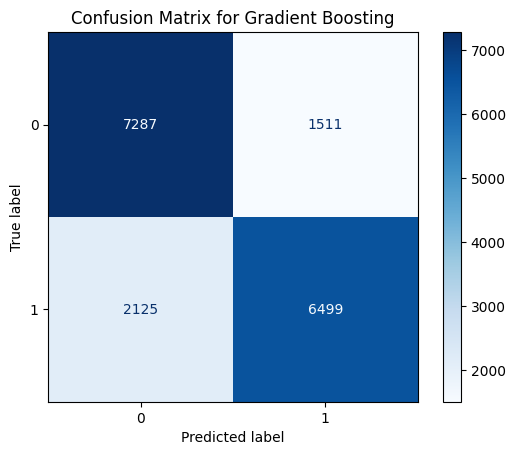

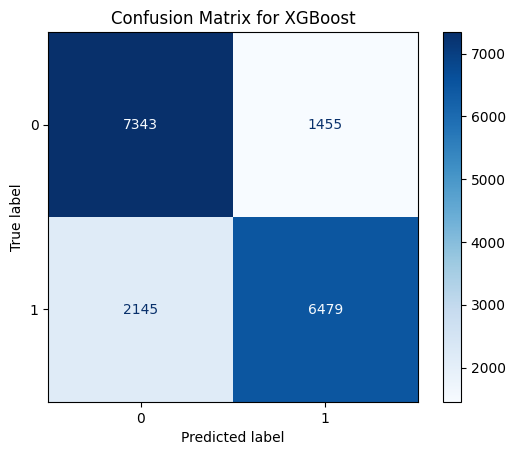

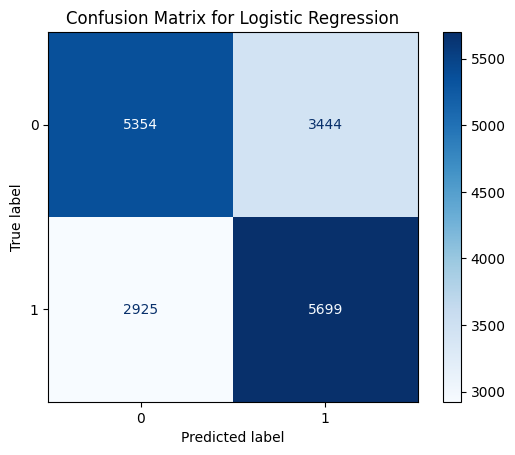

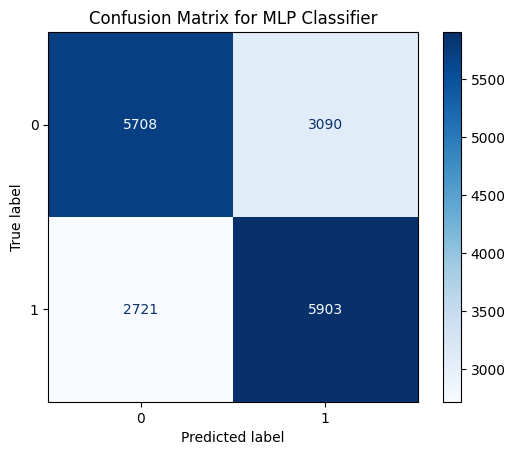

In [104]:
import matplotlib.pyplot as plt

for model_name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, X_test_pca, y_test, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

#### Another boosting model

In [105]:
# Best model from another doccument, fitted on LR data
xgb2 = XGBClassifier(learning_rate=0.01, max_depth=7, n_estimators=1200, random_state=19, use_label_encoder=False, eval_metric='logloss')
xgb2.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:08:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1200,
              n_jobs=None, num_parallel_tree=None, random_state=19, ...)

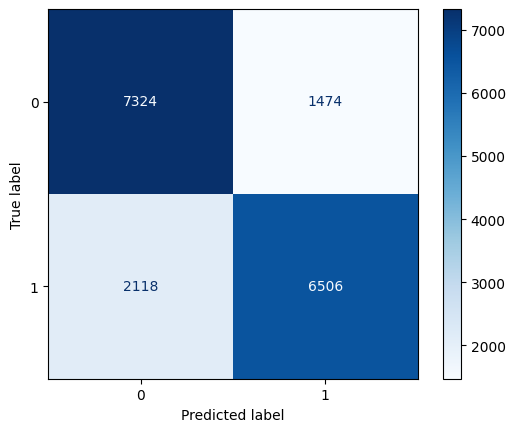

In [106]:
ConfusionMatrixDisplay.from_estimator(xgb2, X_test_pca, y_test, cmap='Blues')

In [107]:
create_model_metrics_df({"XGB2":xgb2}, X_test_pca, y_test)

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,XGB2,0.793824,0.815288,0.754406,0.783667,0.855859


In [108]:
# Model Metrics (On Training version of Test Set (avoiding overfitting))
models = {
    "Decision Tree (PCA)": dt,
    "Bagging (PCA)": bagging,
    "Gradient Boosting": gb,
    "XGBoost": xgb,
    "Logistic Regression": logreg,
    "MLP Classifier": mlp
}

# Create the DataFrame
model_metrics_df = create_model_metrics_df(models, X_test_pca, y_test)


#### **Import Test Set**

In [109]:
#df_test = pd.read_csv('/content/drive/MyDrive/Fall 2024/ISA 491/Final Project/data/group_4_test.csv')
df_test = pd.read_csv('group_4_test.csv')

# Split X and y
X_test_official = df_test.drop('loan_status', axis=1)
y_test_official = df_test['loan_status']

# Rename columns to avoid errors
X_test_official.columns = X_test_official.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Convert to PCA so that we can test our model appropriately
pca_test = PCA(n_components=0.99)
pca_test.fit(X_test_official)
X_test_official_pca = pca.transform(X_test_official)

X_test_official_pca.shape

(95091, 3)

In [110]:
y_test_official.shape

(95091,)

#### Metrics/Confusion Matrixs

                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0  Decision Tree (PCA)  0.756517   0.429452  0.740777  0.543702  0.810586
1        Bagging (PCA)  0.811076   0.511932  0.755760  0.610397  0.851576
2        Random Forest  0.804903   0.501229  0.755384  0.602605  0.848109
3    Gradient Boosting  0.813820   0.516976  0.749852  0.612010  0.855419
4              XGBoost  0.817512   0.523818  0.748778  0.616415  0.857331
5             XGBoost2  0.817385   0.523505  0.751141  0.616996  0.857057
6             XGBoost3  0.824894   0.537731  0.753880  0.627719  0.860841
7  Logistic Regression  0.620679   0.291295  0.653939  0.403052  0.631510
8       MLP Classifier  0.658611   0.323597  0.681811  0.438890  0.707804


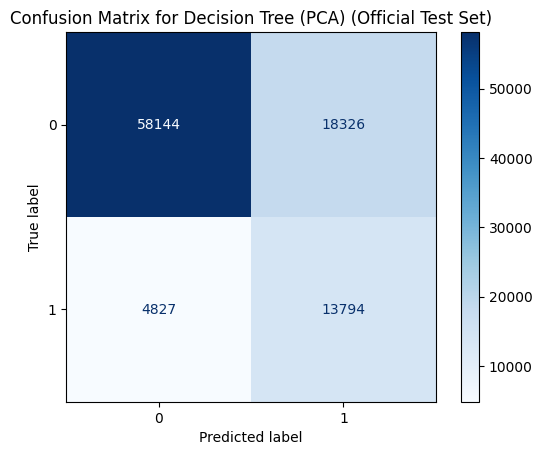

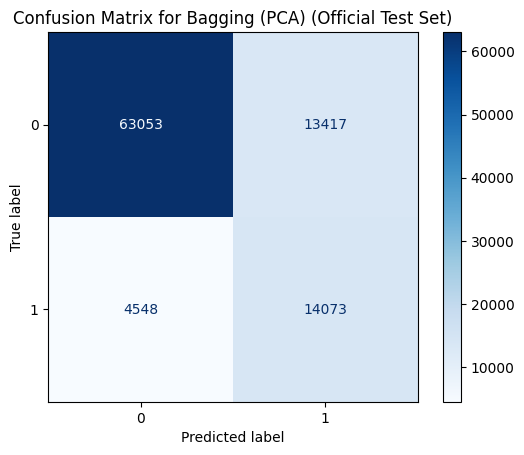

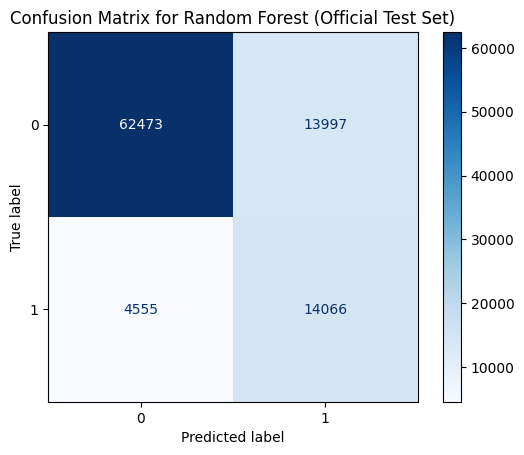

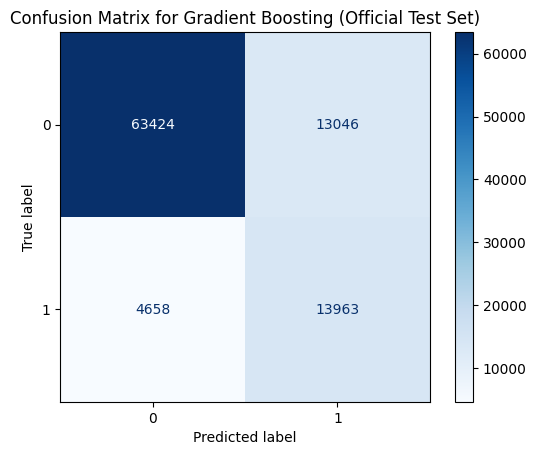

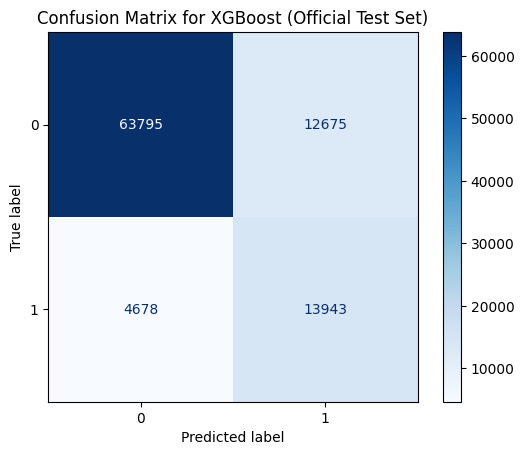

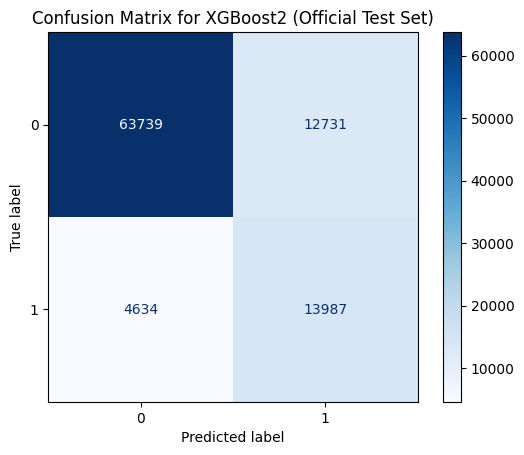

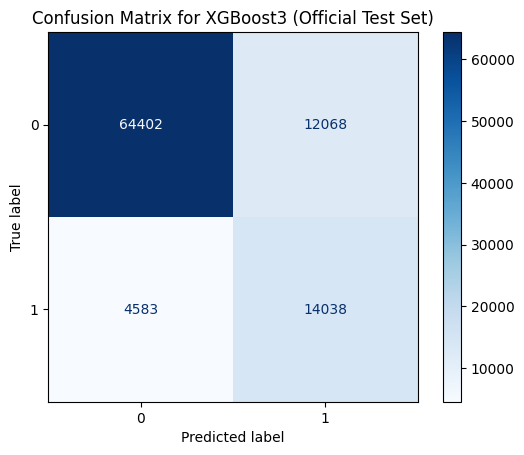

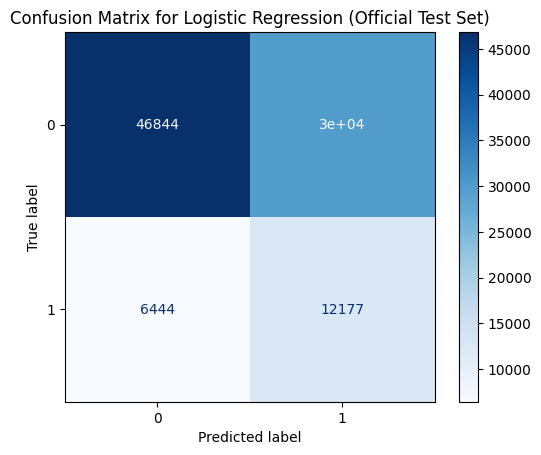

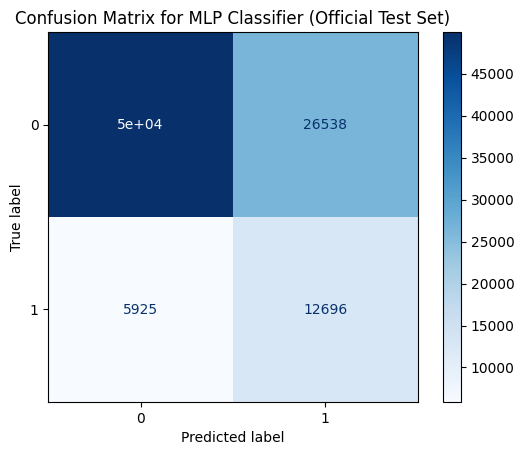

In [111]:
import matplotlib.pyplot as plt

# Create a dictionary of models to test
models_for_testing = {
    "Decision Tree (PCA)": dt,
    "Bagging (PCA)": bagging,
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "XGBoost": xgb,
    "XGBoost2": xgb2,
    "XGBoost3": xgb3,
    "Logistic Regression": logreg,
    "MLP Classifier": mlp,
}

model_metrics_df_official = create_model_metrics_df(models_for_testing, X_test_official_pca, y_test_official)

print(model_metrics_df_official)

for model_name, model in models_for_testing.items():
    ConfusionMatrixDisplay.from_estimator(model, X_test_official_pca, y_test_official, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} (Official Test Set)')
    plt.show()

#### Compute Optimal Threshold

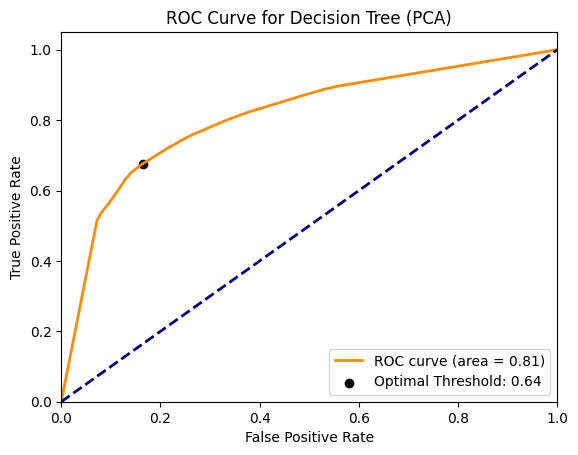

Optimal probability threshold for Decision Tree (PCA): 0.6363636363636364


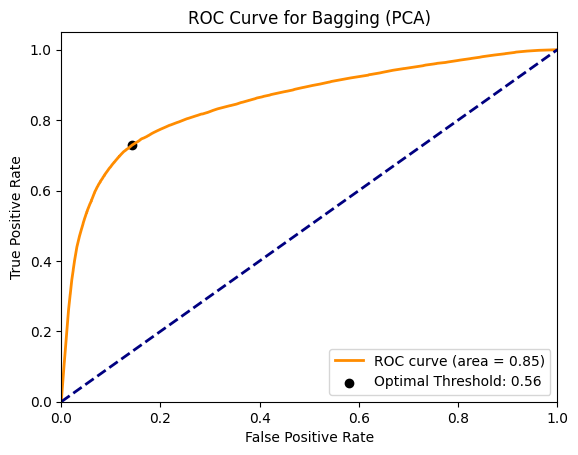

Optimal probability threshold for Bagging (PCA): 0.5598333333333334


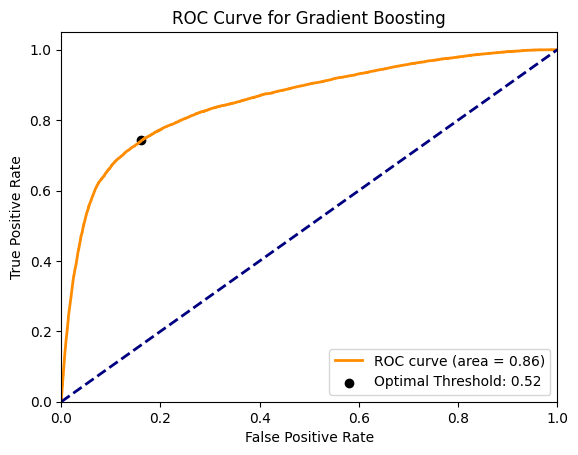

Optimal probability threshold for Gradient Boosting: 0.5155477787213879


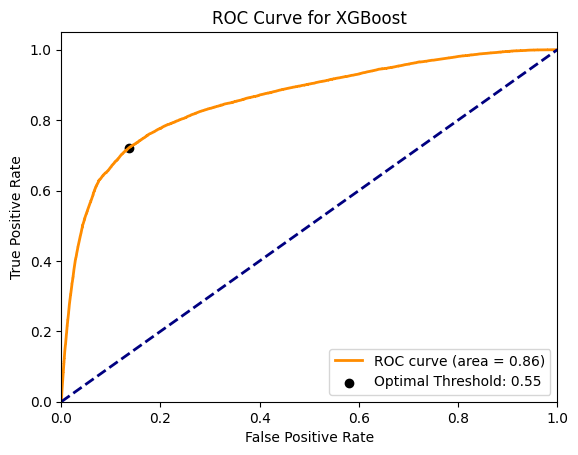

Optimal probability threshold for XGBoost: 0.553280234336853


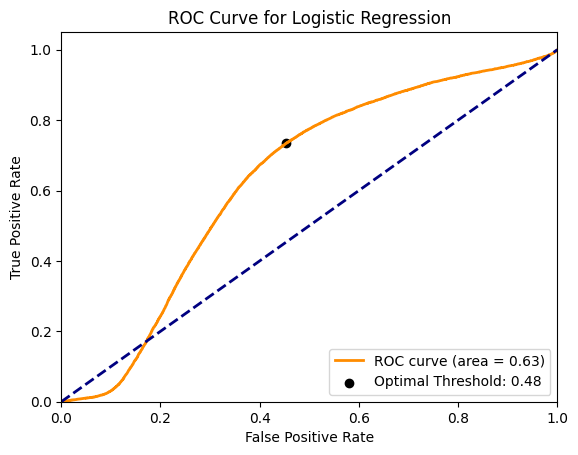

Optimal probability threshold for Logistic Regression: 0.47670361093905284


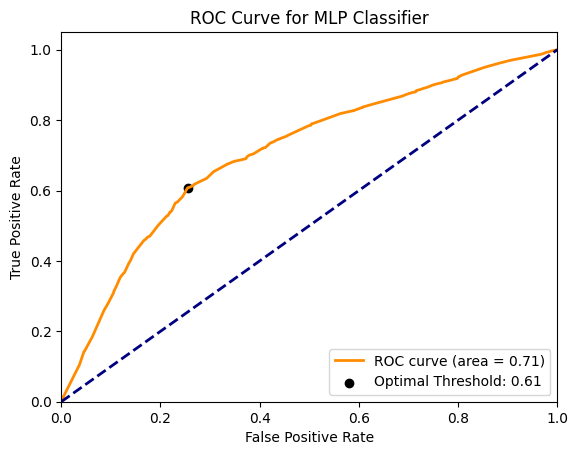

Optimal probability threshold for MLP Classifier: 0.6077296264244045


In [112]:
# prompt: For each model, compute the optimal probability threshold and plot the roc curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

for model_name, model in models.items():
    y_prob = model.predict_proba(X_test_official_pca)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_official, y_prob)
    roc_auc = auc(fpr, tpr)

    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Optimal probability threshold for {model_name}: {optimal_threshold}")

In [ ]:
# Apply thresholds to models

In [115]:
import pandas as pd
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_models_with_optimal_threshold(models, X_test, y_test):
    """
    Evaluates multiple models, finds optimal thresholds, and compiles metrics into a DataFrame.
    """
    results = []
    for model_name, model in models.items():
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_optimal)
            precision = precision_score(y_test, y_pred_optimal)
            recall = recall_score(y_test, y_pred_optimal)
            f1 = f1_score(y_test, y_pred_optimal)
            auc_roc = roc_auc_score(y_test, y_prob)


            results.append({
                'Model': model_name,
                'Optimal Threshold': optimal_threshold,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC-ROC': roc_auc
            })

        except ValueError as e:  # Handle potential errors gracefully
            print(f"Error evaluating {model_name}: {e}")
            results.append({
                'Model': model_name,
                'Optimal Threshold': 'Error',
                'Accuracy': 'Error',
                'Precision': 'Error',
                'Recall': 'Error',
                'F1-Score': 'Error',
                'AUC-ROC': 'Error'
            })
    return pd.DataFrame(results)

# Example usage (assuming models_for_testing, X_test_official_pca, y_test_official are defined):
model_comparison_df = evaluate_models_with_optimal_threshold(models_for_testing, X_test_official_pca, y_test_official)
model_comparison_df

,Model,Optimal Threshold,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Decision Tree (PCA),0.636364,0.804766,0.501114,0.676226,0.575647,0.810586
1,Bagging (PCA),0.559833,0.832087,0.554115,0.729714,0.629905,0.851576
2,Random Forest,0.552778,0.825735,0.540925,0.727566,0.620514,0.848109
3,Gradient Boosting,0.515548,0.819510,0.527831,0.742495,0.617026,0.855419
4,XGBoost,0.553280,0.835778,0.562958,0.721497,0.632444,0.857331
5,XGBoost2,0.552803,0.835431,0.561798,0.725471,0.633229,0.857057
6,XGBoost3,0.561724,0.842740,0.577932,0.730197,0.645203,0.860841
7,Logistic Regression,0.476704,0.583473,0.282901,0.734332,0.408447,0.631510
8,MLP Classifier,0.607730,0.718144,0.367213,0.607486,0.457735,0.707804


In [ ]:
#compare metrics for our models

In [116]:
model_comparison_df = model_comparison_df.sort_values(by='Accuracy', ascending=False)
model_comparison_df

,Model,Optimal Threshold,Accuracy,Precision,Recall,F1-Score,AUC-ROC
6,XGBoost3,0.561724,0.842740,0.577932,0.730197,0.645203,0.860841
4,XGBoost,0.553280,0.835778,0.562958,0.721497,0.632444,0.857331
5,XGBoost2,0.552803,0.835431,0.561798,0.725471,0.633229,0.857057
1,Bagging (PCA),0.559833,0.832087,0.554115,0.729714,0.629905,0.851576
2,Random Forest,0.552778,0.825735,0.540925,0.727566,0.620514,0.848109
3,Gradient Boosting,0.515548,0.819510,0.527831,0.742495,0.617026,0.855419
0,Decision Tree (PCA),0.636364,0.804766,0.501114,0.676226,0.575647,0.810586
8,MLP Classifier,0.607730,0.718144,0.367213,0.607486,0.457735,0.707804
7,Logistic Regression,0.476704,0.583473,0.282901,0.734332,0.408447,0.631510


In [124]:
#save model_comparison_df to csv

model_comparison_df.to_csv('model_comparison.csv', index=False)

Best model is XGBoost3 due to it's higher AUC score, accuracy, and F1-score

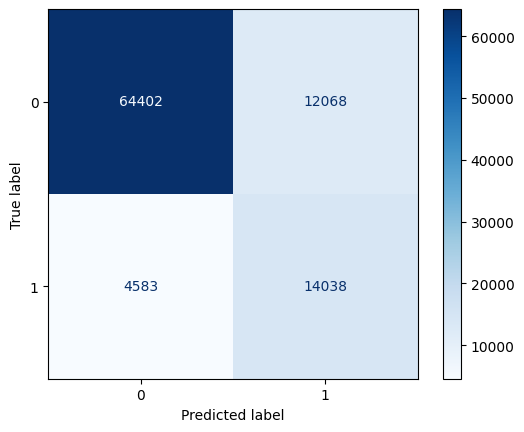

In [117]:
# Confusion Matrix from XGBoost3 (Champion GOAT model)
ConfusionMatrixDisplay.from_estimator(xgb3, X_test_official_pca, y_test_official, cmap='Blues')

In [120]:
import joblib
joblib.dump(xgb3, 'Champion_Model.joblib')

['Champion_Model.joblib']